# 1. 보조지표로 만드는 매매전략 RSI

## (1) 테마 종목 데이터 불러오기
- 테마(본 실험에서는 반도체(DRAM))에 속하는 종목들의 데이터를 가져와 테마 수익률 및 주도주 확인 (ref: https://www.judal.co.kr/?view=stockList&themeIdx=593)
- 안정적인 실험을 위해, 2010년 이후 데이터가 모두 존재하고 삼성전자와 같이 코스피에 속해 유사한 특성일 보일 것이라 기대되는 종목(SK 하이닉스, 한미반도체)만 선택

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

tck_theme = ['005930.KS', '000660.KS', '042700.KS', ] # 삼성전자, SK 하이닉스, 한미반도체

data_theme = pd.DataFrame()

for tck in tck_theme:
    data_tck = pd.read_csv(f'{tck}.csv', index_col=0)
    data_tck = data_tck.loc[(data_tck.index >= '2010') & (data_tck.index < '2024') & (data_tck.Volume > 0)] 

    if tck == '005930.KS':
        data_samsung = data_tck.copy()
    data_theme = pd.concat((data_theme, data_tck['Adj Close']), axis=1)
    data_theme.columns = data_theme.columns.tolist()[:-1] + [tck]

data_theme = data_theme.sort_index().ffill()
data_theme

,005930.KS,000660.KS,042700.KS
2010-01-04,12329.341797,20798.273438,942.436401
2010-01-05,12527.464844,20151.023438,903.168213
2010-01-06,12817.023438,21186.626953,922.802551
2010-01-07,12390.299805,21057.175781,876.989563
2010-01-08,12512.220703,21272.927734,928.037964
...,...,...,...
2023-12-21,74308.851563,139791.562500,58937.722656
2023-12-22,75200.554688,139891.046875,58340.382813
2023-12-26,75894.109375,140189.531250,57344.812500
2023-12-27,77647.140625,139990.125000,61227.535156


In [2]:
# 테마의 n일 수익률 및 최대 수익률(주도주 확인용) 계산

n_days = [1, 5, 10, 15, 20,]

for n in n_days:
    data_theme[f'return_mean_{n}'] = data_theme[tck_theme].ffill().pct_change(n).shift(1).mean(axis=1) # 테마 n일 수익률
    data_theme[f'return_max_{n}'] = data_theme[tck_theme].ffill().pct_change(n).shift(1).max(axis=1) # 테마 주도주의 수익률
    data_theme[f'return_target_{n}'] = data_theme['005930.KS'].pct_change(n).shift(1) # 거래 목표(삼성전자) 수익률, 주도주 여부 확인용
data_theme

,005930.KS,000660.KS,042700.KS,return_mean_1,return_max_1,return_target_1,return_mean_5,return_max_5,return_target_5,return_mean_10,return_max_10,return_target_10,return_mean_15,return_max_15,return_target_15,return_mean_20,return_max_20,return_target_20
2010-01-04,12329.341797,20798.273438,942.436401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,12527.464844,20151.023438,903.168213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,12817.023438,21186.626953,922.802551,-0.018906,0.016069,0.016069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,12390.299805,21057.175781,876.989563,0.032082,0.051392,0.023114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,12512.220703,21272.927734,928.037964,-0.029683,-0.006110,-0.033294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,74308.851563,139791.562500,58937.722656,0.010774,0.019074,0.019074,0.033354,0.070884,0.027473,0.058561,0.118631,0.043236,0.022353,0.077454,0.028886,0.016306,0.070069,0.027473
2023-12-22,75200.554688,139891.046875,58340.382813,0.003731,0.008518,0.002674,0.017930,0.027798,0.025992,0.057558,0.118631,0.048951,0.003443,0.049291,0.030220,0.035825,0.079939,0.035912
2023-12-26,75894.109375,140189.531250,57344.812500,0.000859,0.012000,0.012000,0.014967,0.035471,0.035471,0.040002,0.102745,0.045454,0.019887,0.060332,0.054167,0.040277,0.098438,0.058577
2023-12-27,77647.140625,139990.125000,61227.535156,-0.001903,0.009223,0.009223,0.015059,0.050754,0.050754,0.040113,0.093095,0.049315,0.031020,0.074752,0.055096,0.039066,0.078041,0.074334


<Axes: >

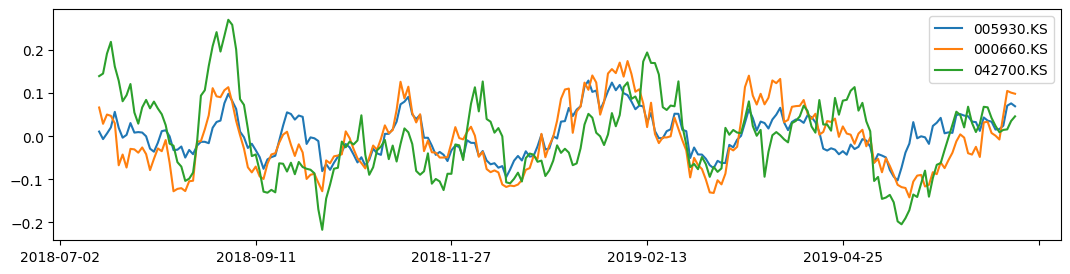

In [3]:
# 10일 수익률로 테마 내 종목간 유사 움직임 확인 (예시 구간: 2018년 7월 ~ 2019년 6월)

data_plot = data_theme.loc[(data_theme.index >'2018-07-01') & (data_theme.index <='2019-07-01'), tck_theme]
(data_plot.pct_change(10)).plot(figsize=(13, 3))

## (2) 제안 매매 알고리즘
- 테마주의 n일 평균 수익률이 기준 이상이고 삼성전자가 주도주가 아닌 경우 매수하고 테마주 수익률이 음수거나 삼성전자가 주도주가 되는 경우 매도하는 알고리즘을 구현한다.
- train 기간(2010~2019)의 데이터로 테마주 수익률을 계산하는 최적의 일 수 n 및 매수 기준 수익률(thres)을 구하고, test 기간(2020~2023)의 데이터로 성능 평가를 진행한다.

In [4]:
### 데이터 분리
t1, t2, t3 = '2010', '2020', '2024'

df_train = data_theme.loc[(data_theme.index >= t1) & (data_theme.index < t2), ['005930.KS']+ [f'return_mean_{n}' for n in n_days]+ [f'return_max_{n}' for n in n_days]+ [f'return_target_{n}' for n in n_days]].iloc[max(n_days):]
df_test = data_theme.loc[(data_theme.index >= t2) & (data_theme.index < t3), ['005930.KS']+ [f'return_mean_{n}' for n in n_days]+ [f'return_max_{n}' for n in n_days]+ [f'return_target_{n}' for n in n_days]].iloc[max(n_days):]

### 1) train: 테마주 수익률을 계산하는 최적의 일 수 n 및 최적 매수 기준 수익률(thres) 조합을 구한다.

In [5]:
################ 전략 파라미터 ##############
n_return_list = n_days
thres_return_list = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2, 0.3]
################ 전략 파라미터 ##############

train_results = pd.DataFrame(columns=['n_return', 'thres_return', 'return', 'num_of_bids'])

for n in n_return_list:
    for thres in thres_return_list:
        ################ 백테스팅 파라미터 #############
        holding_cash = 1_000_000 # 보유 현금
        position = 0 # 현재 보유 포지션
        avg_price = 0 # 평단가
        daily_total_value = [] #일별 총 포트폴리오 가치
        slippage = 0.0025 # 슬리피지 
        ################ 백테스팅 파라미터 #############
        n_bid = 0

        # 한 row 씩 루프
        for idx, row in df_train.iterrows():

            daily_total_value.append(0) # 일별 포트폴리오 가치 List에 새로운 값 추가
            
            # 매수: 테마주 n일 평균 수익률이 thres 이상이고, 삼성전자가 주도주가 아닌 경우
            if (position == 0) and (row[f'return_mean_{n}'] > thres) and (row[f'return_max_{n}'] > row[f'return_target_{n}'] ):
                # 주식 매수 시의 현금 감소, 포지션 증가, 평단가 변화 계산                
                position = int(holding_cash / row['005930.KS'])
                holding_cash -= position * row['005930.KS']
                avg_price = row['005930.KS']
                n_bid += 1

            # 매도: 테마주 n일 평균 수익률이 음수이거나, 삼성전자가 주도주가 되는 경우
            elif (position > 0) and ((row[f'return_mean_{n}'] < 0) or (row[f'return_max_{n}'] == row[f'return_target_{n}'] )):
                holding_cash += (position * row['005930.KS']) * (1-slippage) # 포지션 매도 시 세금/수수료를 제한 값만 현금으로 돌아옴
                position = 0
                avg_price = 0
                days = -1


            daily_total_value[-1]+= holding_cash+ position* row['005930.KS'] # 당일 종료 시점에서 보유 현금 + 주식 평가가치로 총 포트폴리오 가치 계산
            

        train_results.loc[len(train_results)] = [n, thres, daily_total_value[-1]/1_000_000, n_bid]

In [6]:
# 수익률이 가장 좋은 조합을 구한다 
train_results.sort_values(by='return', ascending=False).iloc[:10]

,n_return,thres_return,return,num_of_bids
28,15.0,0.02,1.274183,126.0
31,15.0,0.05,1.266115,68.0
27,15.0,0.01,1.209694,157.0
30,15.0,0.04,1.101894,89.0
41,20.0,0.10,1.091669,32.0
33,15.0,0.15,1.070244,7.0
29,15.0,0.03,1.053784,109.0
4,1.0,0.05,1.043575,16.0
42,20.0,0.15,1.033768,9.0
24,10.0,0.15,1.005161,3.0


### 2) test: 구한 최적의 조합의 성능을 평가한다.

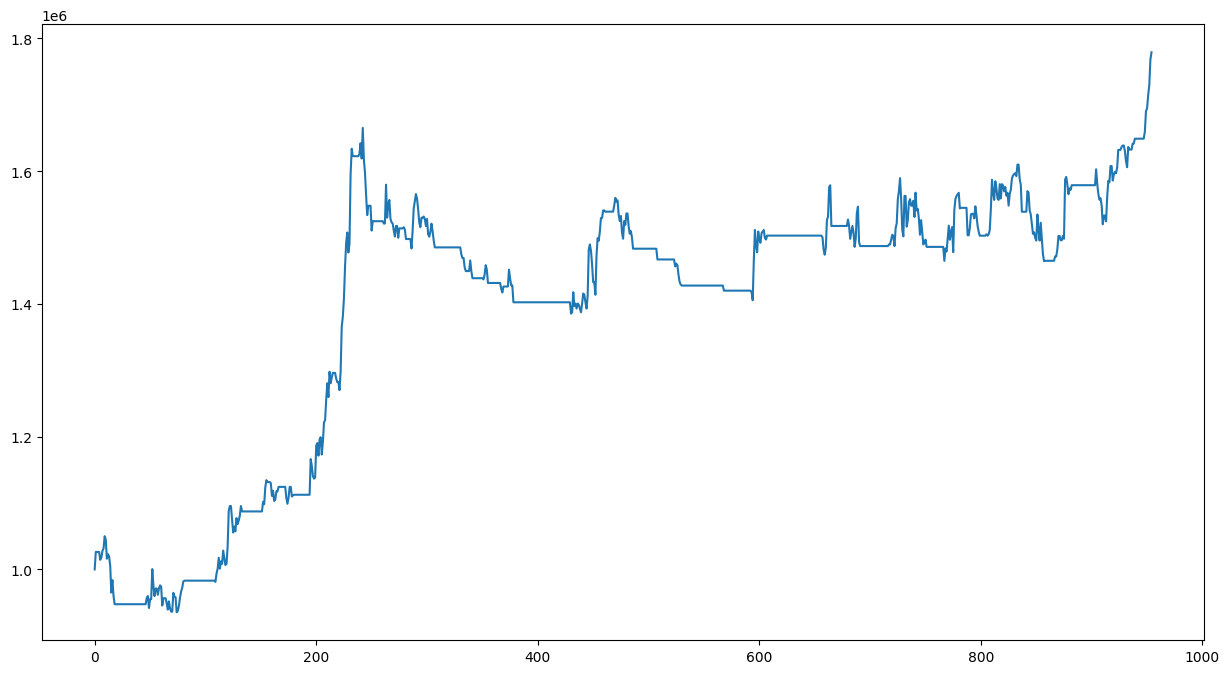

In [7]:
################ 백테스팅 파라미터 #############
holding_cash = 1_000_000 # 보유 현금
position = 0 # 현재 보유 포지션
avg_price = 0 # 평단가
daily_total_value = [] #일별 총 포트폴리오 가치
slippage = 0.0025 # 슬리피지 
################ 백테스팅 파라미터 #############
n_bid = 0

n, thres, _, _ = train_results.sort_values(by='return', ascending=False).iloc[0] # 최적의 조합
n = int(n)

# 한 row 씩 루프
for idx, row in df_test.iterrows():
    daily_total_value.append(0) # 일별 포트폴리오 가치 List에 새로운 값 추가
    
    
    # 매수: 테마주 n일 평균 수익률이 thres 이상이고, 삼성전자가 주도주가 아닌 경우
    if (position == 0) and (row[f'return_mean_{n}'] > thres) and (row[f'return_max_{n}'] > row[f'return_target_{n}'] ):
        # 주식 매수 시의 현금 감소, 포지션 증가, 평단가 변화 계산                
        position = int(holding_cash / row['005930.KS'])
        holding_cash -= position * row['005930.KS']
        avg_price = row['005930.KS']
        n_bid += 1

    # 매도: 테마주 n일 평균 수익률이 음수이거나, 삼성전자가 주도주가 되는 경우
    elif (position > 0) and ((row[f'return_mean_{n}'] < 0) or (row[f'return_max_{n}'] == row[f'return_target_{n}'] )):
        holding_cash += (position * row['005930.KS']) * (1-slippage) # 포지션 매도 시 세금/수수료를 제한 값만 현금으로 돌아옴
        position = 0
        avg_price = 0


    daily_total_value[-1]+= holding_cash+ position* row['005930.KS'] # 당일 종료 시점에서 보유 현금 + 주식 평가가치로 총 포트폴리오 가치 계산

    
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
plt.plot(daily_total_value)

### (3) 전략 성과 측정

총 수익률: 77.91%
------------------------------------------------
총 백테스팅 기간: 3.82년
연 수익률: 16.28%
------------------------------------------------
일 수익률: 0.06%, 일 변동성: 0.01%
Sharpe ratio: 0.93
------------------------------------------------
MDD: -16.80%


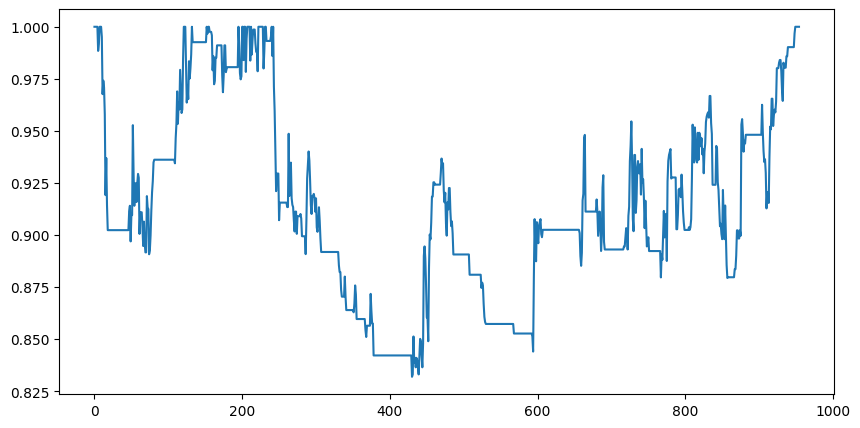

------------------------------------------------


In [8]:
# 전략 총 수익률 계산
total_return_pct = daily_total_value[-1]/daily_total_value[0]
print('총 수익률: {:.2f}%'.format((total_return_pct-1)*100))

print('------------------------------------------------')

# 1년을 250일로 가정, 연 복리 수익률 계산
total_years = len(daily_total_value)/250
print('총 백테스팅 기간: {:.2f}년'.format(total_years))

import math
annaul_return = math.pow(total_return_pct,1/total_years)

print('연 수익률: {:.2f}%'.format((annaul_return-1)*100))

print('------------------------------------------------')

# Sharpe Ratio
daily_return = math.pow(total_return_pct,1/len(daily_total_value))
daily_std = pd.DataFrame(daily_total_value).pct_change().std()[0]

print('일 수익률: {:.2f}%, 일 변동성: {:.2f}%'.format((daily_return-1)*100,daily_std))
print('Sharpe ratio: {:.2f}'.format(((daily_return-1)/daily_std)*np.sqrt(250)))

print('------------------------------------------------')

# MDD 계산
tv = pd.DataFrame(daily_total_value)
dd = tv/tv.cummax()
print('MDD: {:.2f}%'.format((dd.min()-1)[0]*100))


plt.figure(figsize=(10,5))
plt.plot(dd)
plt.show()

print('------------------------------------------------')


### 4) 벤치마크와의 비교

총 수익률: 52.91%
------------------------------------------------
총 백테스팅 기간: 3.82년
연 수익률: 11.76%
------------------------------------------------
일 수익률: 0.04%, 일 변동성: 0.02%
Sharpe ratio: 0.44
------------------------------------------------
MDD: -40.14%


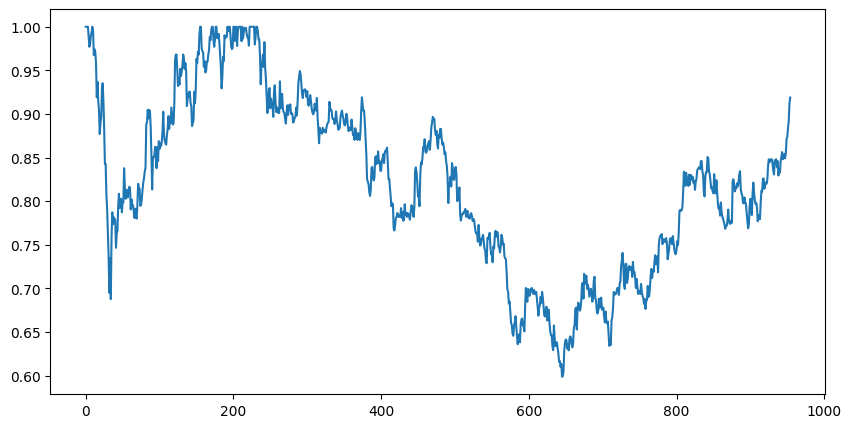

------------------------------------------------


In [9]:
# 삼성전자 Buy & Hold의 수익률 계산

bm_daily_total_value = df_test['005930.KS'].values/df_test['005930.KS'].values[0]

# 전략 총 수익률 계산
total_return_pct = bm_daily_total_value[-1]/bm_daily_total_value[0]
print('총 수익률: {:.2f}%'.format((total_return_pct-1)*100))

print('------------------------------------------------')

# 1년을 250일로 가정, 연 복리 수익률 계산
total_years = len(bm_daily_total_value)/250
print('총 백테스팅 기간: {:.2f}년'.format(total_years))

import math
annaul_return = math.pow(total_return_pct,1/total_years)

print('연 수익률: {:.2f}%'.format((annaul_return-1)*100))

print('------------------------------------------------')

# Sharpe Ratio
daily_return = math.pow(total_return_pct,1/len(bm_daily_total_value))
daily_std = pd.DataFrame(bm_daily_total_value).pct_change().std()[0]

print('일 수익률: {:.2f}%, 일 변동성: {:.2f}%'.format((daily_return-1)*100,daily_std))
print('Sharpe ratio: {:.2f}'.format(((daily_return-1)/daily_std)*np.sqrt(250)))

print('------------------------------------------------')

# MDD 계산
tv = pd.DataFrame(bm_daily_total_value)
dd = tv/tv.cummax()
print('MDD: {:.2f}%'.format((dd.min()-1)[0]*100))


plt.figure(figsize=(10,5))
plt.plot(dd)
plt.show()

print('------------------------------------------------')
